In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support

C:\Users\mihir\AppData\Local\Temp\ipykernel_20064\1602047291.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  longitudinal_monthly = longitudinal_series.resample('M').mean()


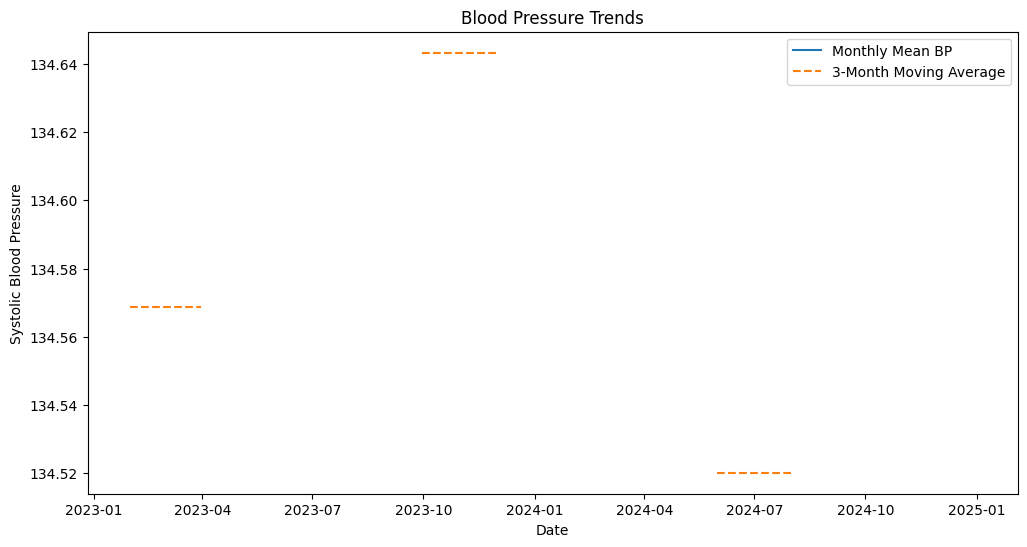

visit_date
2023-01-17 00:00:00+00:00    111.0
2023-09-23 00:00:00+00:00    112.0
2024-05-22 00:00:00+00:00    111.2
2024-12-31 00:00:00+00:00    109.2
2023-01-17 00:00:00+00:00    146.1
dtype: float64


In [2]:
# Time Series
baseline_data = pd.read_csv('patient_baseline.csv', sep='\t')
longitudinal_data = pd.read_csv('patient_longitudinal.csv', sep='\t')
treatment_data = pd.read_csv('patient_treatment.csv', sep='\t')

# Parse visit_date column as datetime
longitudinal_data['visit_date'] = pd.to_datetime(longitudinal_data['visit_date'], format='%Y-%m-%d')

# Handle duplicates
longitudinal_data = longitudinal_data.drop_duplicates(subset=['patient_id', 'visit_date'])

# Handle missing values using interpolation
longitudinal_data = longitudinal_data.interpolate()

# Create a pandas Series with DatetimeIndex
longitudinal_series = pd.Series(longitudinal_data['bp_systolic'].values, index=longitudinal_data['visit_date'])

# Timezone Handling
longitudinal_series = longitudinal_series.tz_localize('UTC')

# Resample to monthly frequency using mean aggregation
longitudinal_monthly = longitudinal_series.resample('M').mean()

# 3-month moving averages
monthly_bp_ma = longitudinal_monthly.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(12, 6))
plt.plot(longitudinal_monthly, label='Monthly Mean BP')
plt.plot(monthly_bp_ma, label='3-Month Moving Average', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure')
plt.title('Blood Pressure Trends')
plt.legend()
plt.show()

print(longitudinal_series.head())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     149.1
Date:                Mon, 04 Nov 2024   Prob (F-statistic):          6.36e-100
Time:                        07:08:34   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.0

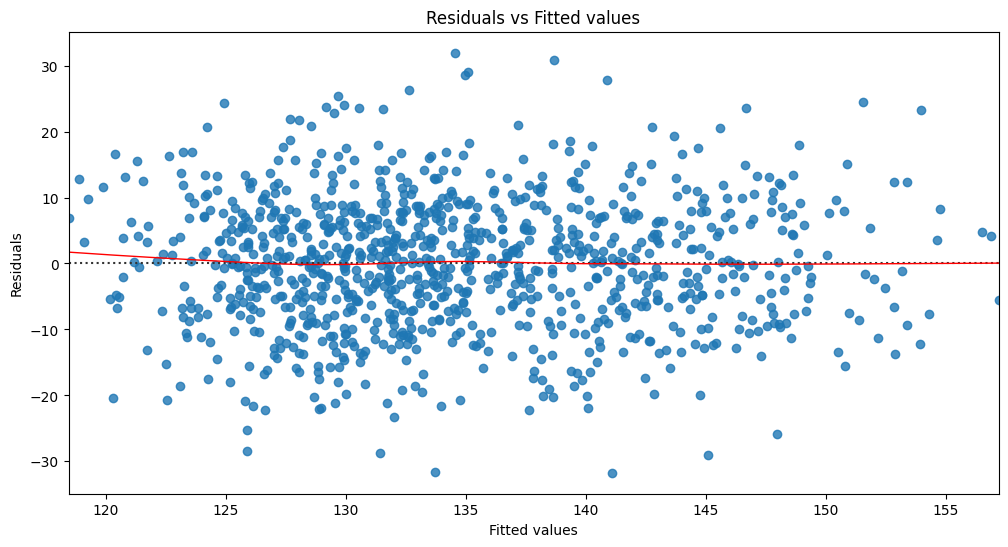

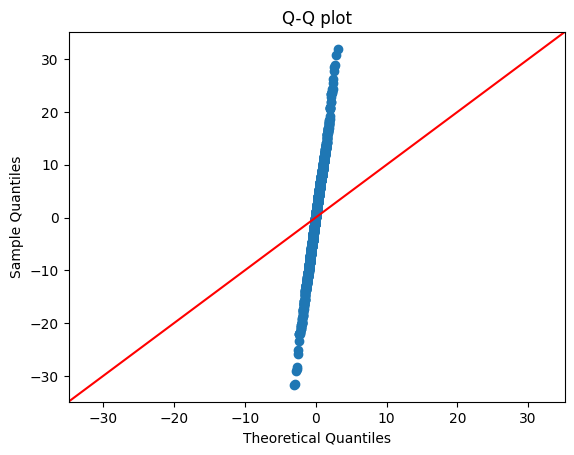

               2.5%      97.5%        OR
const      0.032339   0.464910  0.122616
age        0.999248   1.018362  1.008759
bmi        0.972373   1.028004  0.999802
smoking    0.531695   1.175584  0.790602
diabetes   0.477048   0.946964  0.672122
adherence  1.809626  24.750303  6.692442
Residual Deviance: 1296.4508842795383
Null Deviance: 1334.774434101428


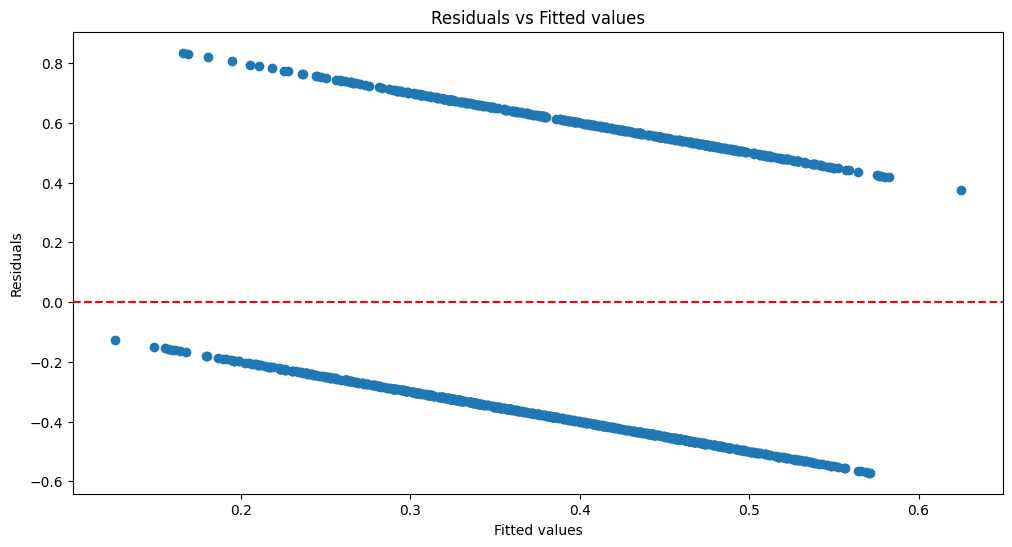

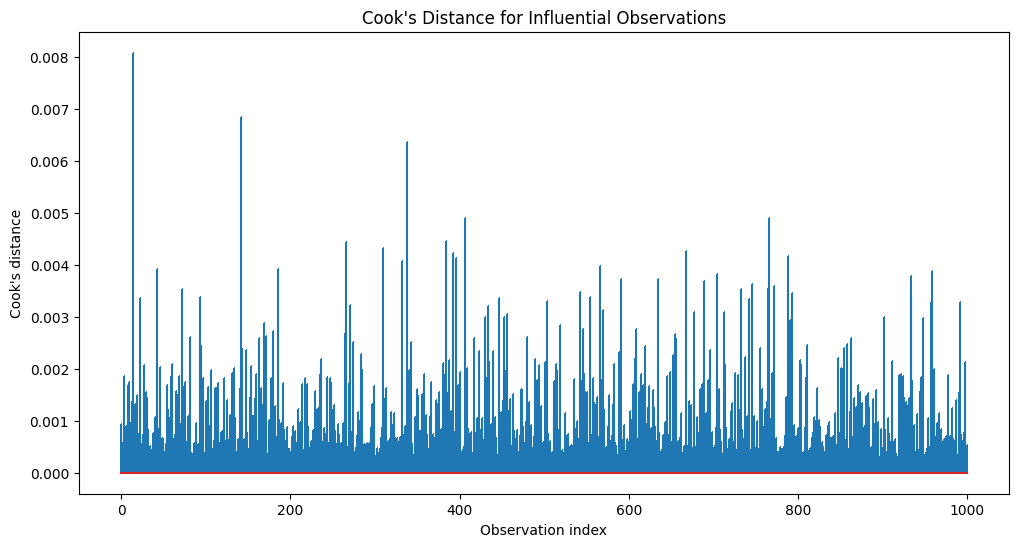

In [3]:
# Statistical Modeling

# feature matrix X and target variable y
X = baseline_data[['age', 'bmi', 'smoking', 'diabetes']]
y = baseline_data['bp_systolic']

# Add a constant term to the feature matrix
X = sm.add_constant(X)

# OLS model
model = sm.OLS(y, X).fit(cov_type='HC3')

# summary p-values and confidence intervals
print(model.summary())

# Residuals vs Fitted values
plt.figure(figsize=(12, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q plot')
plt.show()

# feature matrix X and target variable y
X = treatment_data[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y = treatment_data['outcome']

# Add a constant term to the feature matrix
X = sm.add_constant(X)

# Fit the GLM with binomial family
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Report odds ratios and their confidence intervals
odds_ratios = np.exp(model.params)
conf = np.exp(model.conf_int())
conf['OR'] = odds_ratios
conf.columns = ['2.5%', '97.5%', 'OR']
print(conf)

# Model fit using deviance
print(f"Residual Deviance: {model.deviance}")
print(f"Null Deviance: {model.null_deviance}")

# Residuals vs Fitted values
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, model.resid_response)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(0, color='red', linestyle='--')
plt.show()

# Influence plot to detect influential observations
influence = model.get_influence()
(cooks_d, pvals) = influence.cooks_distance
plt.figure(figsize=(12, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Influential Observations")
plt.show()

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       122
           1       0.48      0.63      0.54        78

    accuracy                           0.58       200
   macro avg       0.59      0.59      0.58       200
weighted avg       0.61      0.58      0.59       200

Regularization strength (C=0.01):
              precision    recall  f1-score   support

           0       0.68      0.56      0.61       122
           1       0.46      0.59      0.52        78

    accuracy                           0.57       200
   macro avg       0.57      0.57      0.56       200
weighted avg       0.59      0.57      0.58       200

Regularization strength (C=0.1):
              precision    recall  f1-score   support

           0       0.70      0.57      0.62       122
           1       0.48      0.62      0.54        78

    accuracy                           0.58       200
   macro avg       0.59      0.59      0.58       200
weighte

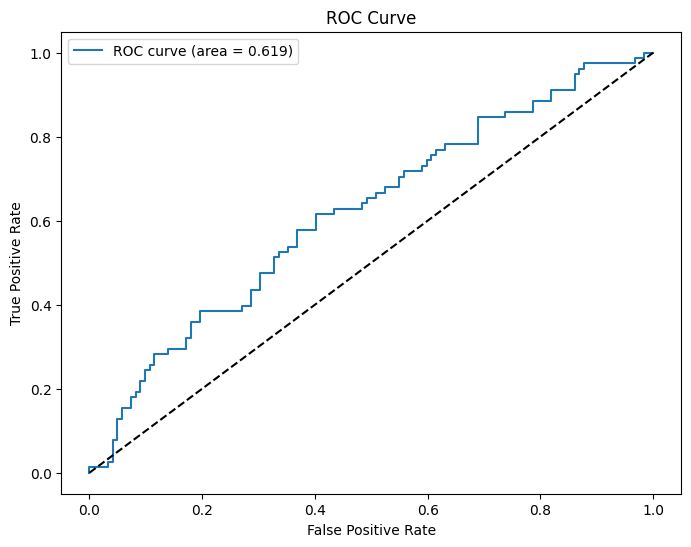

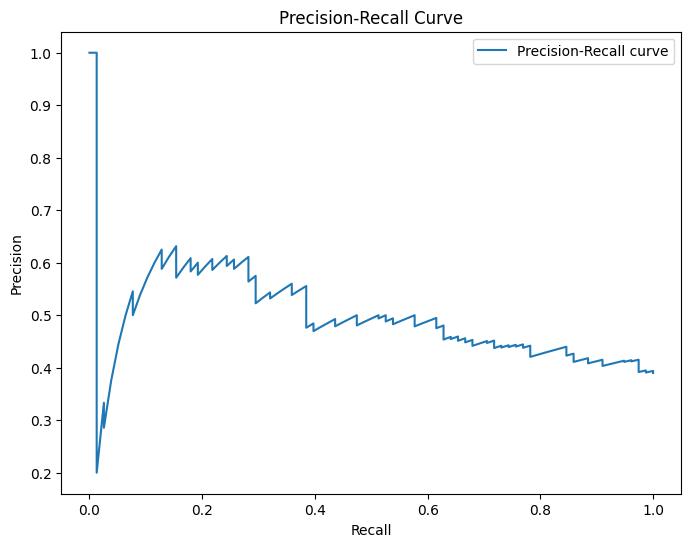

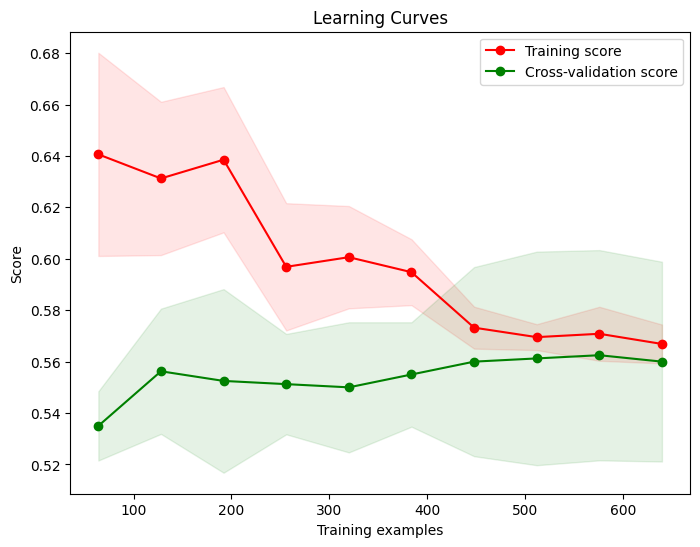

In [4]:
# Machine Learning 

# feature matrix X and target variable y
X = treatment_data[['age', 'bmi', 'smoking', 'diabetes', 'adherence']]
y = treatment_data['outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical variables
numeric_features = ['age', 'bmi', 'adherence']
categorical_features = ['smoking', 'diabetes']

# ColumnTransformer to handle preprocessing for different feature types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# pipeline with preprocessing, feature selection, and logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k='all')),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, class_weight='balanced'))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Different regularization strengths with C parameter
for C in [0.01, 0.1, 1, 10, 100]:
    pipeline.set_params(classifier__C=C)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Regularization strength (C={C}):")
    print(classification_report(y_test, y_pred))


# 5-fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']
cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)

# Cross-validation results
print("Cross-validation results:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results['test_' + metric]):.3f} ± {np.std(cv_results['test_' + metric]):.3f}")

# Train the model on the entire training set
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Accuracy, precision, recall, and ROC AUC
print("Test set performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# Precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Plot learning curves to diagnose bias/variance
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.show()